# 1. Importing the libraries

In [169]:
# Dataframe manipulation
import numpy as np
import pandas as pd
# To analyze the type of missing data
import missingno as msno

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid',context = 'notebook')

# Preprocessing
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, LabelEncoder, scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, scale

# Modelling Helpers:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


----------------------------------------------------------------------------------------------------------------------

# 2. Common function

In [170]:
#######################################################################
### DefineTarget
#######################################################################
def DefineTarget(target_val):
    if(target_val == 'Yes'):
        target_val = 1
    else:
        target_val = 0
    
    return target_val


#######################################################################
### Descriptive Statistics
#######################################################################
def DescriptiveStatistics(df):
    countvar = df.count()
    meanvar = np.round(df.mean(),1)
    minvar = df.min()
    maxvar = df.max()
    stdvar = np.round(df.std(),1)
    statistics_df = pd.concat([meanvar,minvar,maxvar,stdvar,countvar],axis=1)
    statistics_df = pd.DataFrame(statistics_df).reset_index()
    orgname = list(statistics_df.columns.values)
    statistics_df.rename(columns={orgname[0]:'variable',
                                  orgname[1]:'mean',
                                  orgname[2]:'min',
                                  orgname[3]:'max',
                                  orgname[4]:'std',
                                  orgname[5]:'non_missing'},
                                  inplace = True)
    statistics_df['Total'] = df.shape[0]
    statistics_df['miss_per'] = np.round(100*(statistics_df['Total'] - statistics_df['non_missing'])/statistics_df['Total'],1)
    
    return statistics_df


#######################################################################
### Check_Missing_Data
#######################################################################
def Check_Missing_Data(df):    
    # count all missing values of each column
    total = df.isnull().sum().sort_values(ascending=False)
    # calculate percentage of null values for each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data


#######################################################################
### Create dummy varibales
#######################################################################
def CreateDummyVar(df, categorical_list):
    objdf_new = df.copy()
    objdf_dummy =pd.DataFrame()
    i = 0
    for e in categorical_list:
        i = i + 1
        objdf_new[e]=objdf_new[e] + "_" + str(i)
        varname= e 
        df_temp = pd.get_dummies(objdf_new[varname])
        objdf_dummy = pd.concat([objdf_dummy, df_temp], axis=1)
        
    return objdf_dummy


#######################################################################
### Check frequency of each level in categorical variable
#######################################################################
def analyse_frequency_labels(df, var):
    df = df.copy()
    df['id'] = df.index.values
    tmp = df.groupby(var)['id'].count()/len(df)
    return tmp


#######################################################################
### Levels that are present only in a small number
#######################################################################
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    df['id'] = df.index.values
    tmp = df.groupby(var)['id'].count()/len(df)
    return tmp[tmp < rare_perc]


#######################################################################
### ModelSelection
#######################################################################
def ModelSelection(X_train, y_train, X_test, y_test):
    
    # Import libraries
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC, LinearSVC
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    from xgboost import XGBClassifier
    from sklearn.neural_network import MLPClassifier
    
    # Test options and evaluation metric
    seed = 7
    scoring = 'accuracy'
    
    # Initialize the classifier models with their default parameters and add them to the list
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVC', SVC(kernel="linear")))
    models.append(('LSVC', SVC(kernel="rbf")))
    models.append(('LR', LogisticRegression()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGB',LGBMClassifier()))
    models.append(('ADA',AdaBoostClassifier()))
    models.append(('QDA',QuadraticDiscriminantAnalysis()))
    models.append(('NN',MLPClassifier()))
    models.append(('XGB',XGBClassifier()))
    
    # Train model
    # evaluate each model in turn
    from sklearn import model_selection
    from sklearn.model_selection import train_test_split
    results = {}
    names = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state = seed)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results[name] = cv_results
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    
    results_df = pd.DataFrame(results)
    print(results_df)
    
    plt.figure(figsize=(15,10))
    sns.boxplot(data=results_df)
    plt.show()
    
    # Make predictions on validation dataset
    for name, model in models:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(name)
        print('Accuracy score: ',accuracy_score(y_test, predictions))
        print(classification_report(y_test, predictions))

----------------------------------------------------------------------------------------------------------------------

# 3. Importing the dataset

In [198]:
df = pd.read_csv('iris.csv')
print(df.shape)
df.head()

(150, 5)


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [199]:
df['Species'].value_counts()

Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: Species, dtype: int64

----------------------------------------------------------------------------------------------------------------------

# 4. Data Preparation

### 4.1. Select and remove unnesscary variables

In [200]:
removed_list = []
print(len(removed_list))
selected_features = [e for e in df.columns if e not in removed_list]
print(len(selected_features))
df = df[selected_features]
df.head()

0
5


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 4.2. Rename columns

### 4.3. Remove duplicated rows

### 4.4. Define target variable

### 4.5. Reset index

In [201]:
dataset = dataset.reset_index(drop = True)
dataset.shape
dataset.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


----------------------------------------------------------------------------------------------------------------------

# 5. Descriptive Statistics

### 5.1. Data structure

In [202]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


### 5.2. Descriptive Statistics

In [203]:
dataset.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [204]:
stats_df = DescriptiveStatistics(dataset)
stats_df

,variable,mean,min,max,std,non_missing,Total,miss_per
0,PetalLengthCm,3.8,1,6.9,1.8,150,150,0.0
1,PetalWidthCm,1.2,0.1,2.5,0.8,150,150,0.0
2,SepalLengthCm,5.8,4.3,7.9,0.8,150,150,0.0
3,SepalWidthCm,3.1,2,4.4,0.4,150,150,0.0
4,Species,NaN,Iris-setosa,Iris-virginica,NaN,150,150,0.0


----------------------------------------------------------------------------------------------------------------------

# 6. Check missing data

### 6.1 Check missing data

In [205]:
missing_values_df = Check_Missing_Data(dataset)
missing_values_df

,Total,Percent
Species,0,0.0
PetalWidthCm,0,0.0
PetalLengthCm,0,0.0
SepalWidthCm,0,0.0
SepalLengthCm,0,0.0


### 6.2. Selecting columns with low rate of missing data

In [206]:
selected_columns_df = missing_values_df.loc[missing_values_df.Percent <= 0.3,:]
selected_columns = selected_columns_df.index.values
df = df[selected_columns]
df.shape

(150, 5)

### 6.3. Relationship between values being missing and target value

In [207]:
df1 = df.loc[df.Species=='Iris-setosa',:]
df2 = df.loc[df.Species=='Iris-virginica',:]
df3 = df.loc[df.Species=='Iris-versicolor',:]

In [208]:
missing_df1 = df1.columns[df1.isnull().any()].tolist()
missing_df1
#msno.matrix(df1[missing_df1],figsize=(5,10))

[]

----------------------------------------------------------------------------------------------------------------------

# 7. Target variable Analysis

In [209]:
le = LabelEncoder()
df[['Species']]= df[['Species']].apply(le.fit_transform)
df.head()

,Species,PetalWidthCm,PetalLengthCm,SepalWidthCm,SepalLengthCm
0,0,0.2,1.4,3.5,5.1
1,0,0.2,1.4,3.0,4.9
2,0,0.2,1.3,3.2,4.7
3,0,0.2,1.5,3.1,4.6
4,0,0.2,1.4,3.6,5.0


In [210]:
df.Species.value_counts()/df.shape[0]

2    0.333333
1    0.333333
0    0.333333
Name: Species, dtype: float64

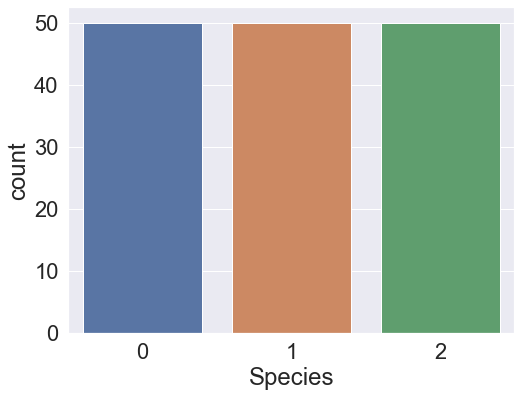

In [211]:
plt.figure(figsize = (8,6))
sns.countplot(x='Species', data = df)
plt.show()

# 8. Explore variables

## 8.1. Categorical variables

### 8.1.1 List of categorical variables 

In [212]:
cat_vars = [var for var in df.columns if df[var].dtypes=='O']
print('Number of categorical variables: ', len(cat_vars))
# let's visualise the values of the categorical variables
df[cat_vars].head(3)

Number of categorical variables:  0


""
0
1
2


### 8.1.2 Convert categorical variables to numerical variables

In [213]:
num_list =[]
for var in num_list:
    df[var] = (df[var].str.replace(r'[^-+\d.]', '').astype(float))
    print(df[var].dtype)

### 8.1.3 Remove temporal vars and text vars

In [214]:
temporal_vars = []
text_vars = []
cat_vars = [var for var in cat_vars if var not in text_vars+temporal_vars+num_list]
print(len(cat_vars))
cat_vars

0


[]

### 8.1.4. Levels (cardinality) of each cat var

In [215]:
for var in cat_vars:
    print(var, len(df[var].unique()),' categories')

All the categorical variables show low cardinality, this means that they have only few different labels. That is good as we won't need to tackle cardinality during our feature engineering stage

### 8.1.5 Frequency of each level in each cat var

In [216]:
for var in cat_vars:
    print(analyse_frequency_labels(df,var))
    print()

### 8.1.6. Levels that are present only in a small number

investigate if there are labels that are present only in a small number of houses

In [217]:
for var in cat_vars:
    print(analyse_rare_labels(df,var,0.01))
    print()

### 8.1.7. Relationship between categorical variables and target

### 8.1.8. Selected categorical variables

In [218]:
removed_cols = ['Species']  # target variables
cat_vars = [e for e in cat_vars if e not in removed_cols]
objdf = objdf.loc[:,cat_vars]
objdf.head()

""
0
1
2
3
4


## 8.2. Numerical variables

### 8.2.1. List of numerical variables

In [219]:
num_vars = [var for var in df.columns if df[var].dtypes != 'O']
print('Number of numerical variables', len(num_vars))
df[num_vars].head()

Number of numerical variables 5


,Species,PetalWidthCm,PetalLengthCm,SepalWidthCm,SepalLengthCm
0,0,0.2,1.4,3.5,5.1
1,0,0.2,1.4,3.0,4.9
2,0,0.2,1.3,3.2,4.7
3,0,0.2,1.5,3.1,4.6
4,0,0.2,1.4,3.6,5.0


In [220]:
# Create a sub-dataframe to store all numeric variables in the whole data frame
datatypes= ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = dataset.select_dtypes(include=datatypes)

numerical_list = numdf.columns
print(numerical_list)
numdf.head()

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### 8.2.2. Remove unnesscary columns

In [222]:
removed_cols = ['Species']
num_vars = [e for e in num_vars if e not in removed_cols]
num_vars

['PetalWidthCm', 'PetalLengthCm', 'SepalWidthCm', 'SepalLengthCm']

### 8.2.3. Discrete variables

In [223]:
removed_list = []
discrete_vars = [var for var in num_vars if len(df[var].unique()) < 20 and var not in removed_list]
print('Number of discrete variables: ', len(discrete_vars))
df[discrete_vars].head()

Number of discrete variables:  0


""
0
1
2
3
4


#### Analyze distribution of discrete vars

### 8.2.4. Continuous variables

In [224]:
cont_vars = [var for var in num_vars if var not in discrete_vars]
print('Number of continuous variables: ',len(cont_vars))
df[cont_vars].head()

Number of continuous variables:  4


,PetalWidthCm,PetalLengthCm,SepalWidthCm,SepalLengthCm
0,0.2,1.4,3.5,5.1
1,0.2,1.4,3.0,4.9
2,0.2,1.3,3.2,4.7
3,0.2,1.5,3.1,4.6
4,0.2,1.4,3.6,5.0


### 8.2.5. Correlation matrix

[]

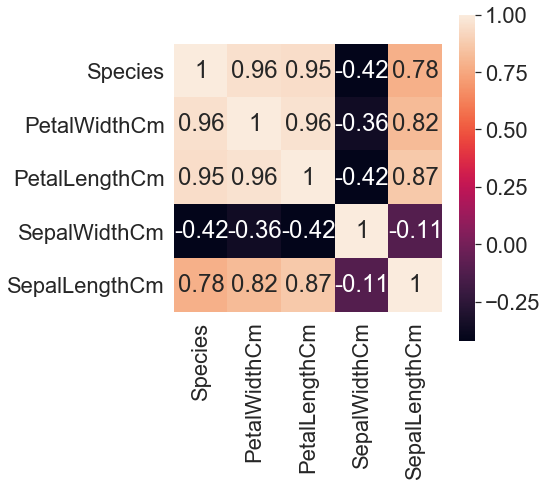

In [225]:
corr = df.corr()
plt.figure(figsize = (6,6))
sns.heatmap(data = corr, annot = True, square = True, cbar = True)
plt.plot()

### 8.2.6 Violin plot

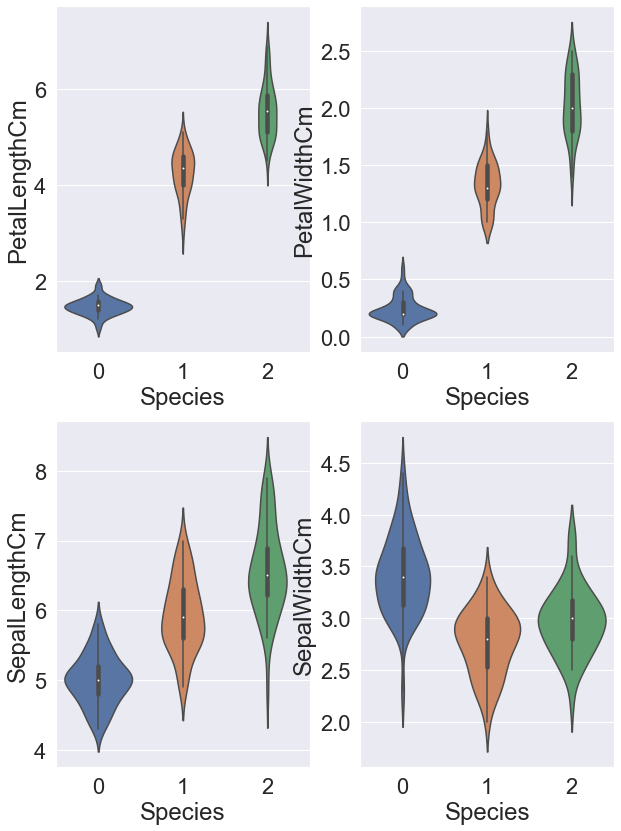

In [226]:
plt.figure(figsize = (10,14))

plt.subplot(2,2,1)
sns.violinplot(x='Species',y='PetalLengthCm', data = df)

plt.subplot(2,2,2)
sns.violinplot(x='Species',y='PetalWidthCm', data = df)

plt.subplot(2,2,3)
sns.violinplot(x='Species',y='SepalLengthCm', data=df)

plt.subplot(2,2,4)
sns.violinplot(x='Species',y='SepalWidthCm', data=df)

plt.show()

### 8.2.7. Histogram distribution

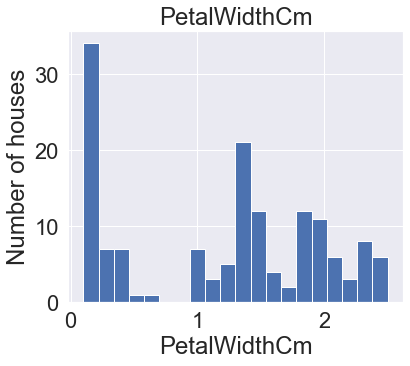

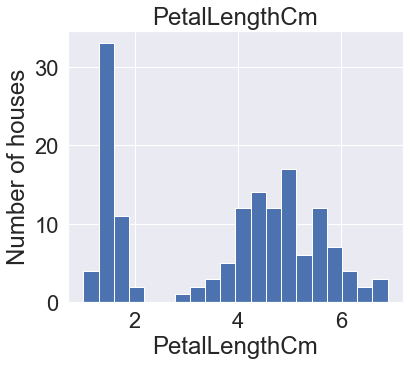

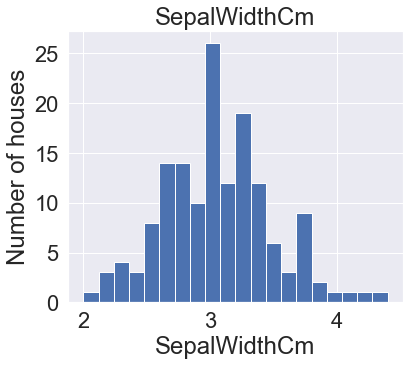

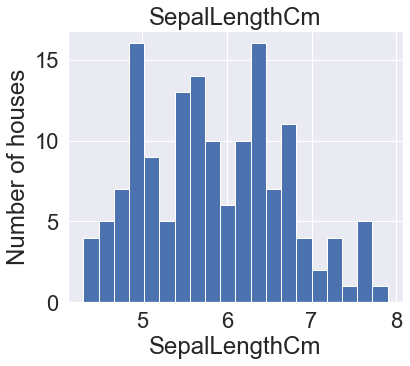

In [227]:
def Histogram_plot(df, var):
    df = df.copy()
    df[var].hist(bins=20,figsize = (6,5))
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in cont_vars:
    Histogram_plot(df, var)

### 8.2.8 Scatter plot

In [228]:
def Scatter_plot(df, var1, var2):
    df = df.copy()
    plt.figure(figsize=(7,5))
    plt.scatter(df[var1],df[var2],c=df['Color'])
    plt.ylabel(var2)
    plt.xlabel(var1)
    plt.show()


df['Color'] = 0
df.loc[df.Species == 'Iris-versicolor','Color'] = 1
df.loc[df.Species == 'Iris-virginica','Color'] = 2
i = 0    

for var in np.arange(1,len(cont_vars)-1):
    var1 = cont_vars[i]
    if (next_var < len(cont_vars)):
        var2 = cont_vars[var+1]
        Scatter_plot(df, var1, var2)

In [229]:
var1

'PetalWidthCm'

In [230]:
var2

'SepalLengthCm'

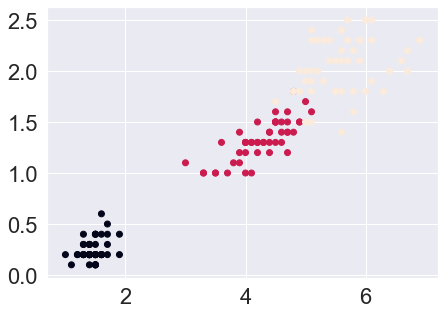

In [232]:
plt.figure(figsize = (7,5))
plt.scatter(df['PetalLengthCm'], df['PetalWidthCm'], c=df['Species'])
plt.show()

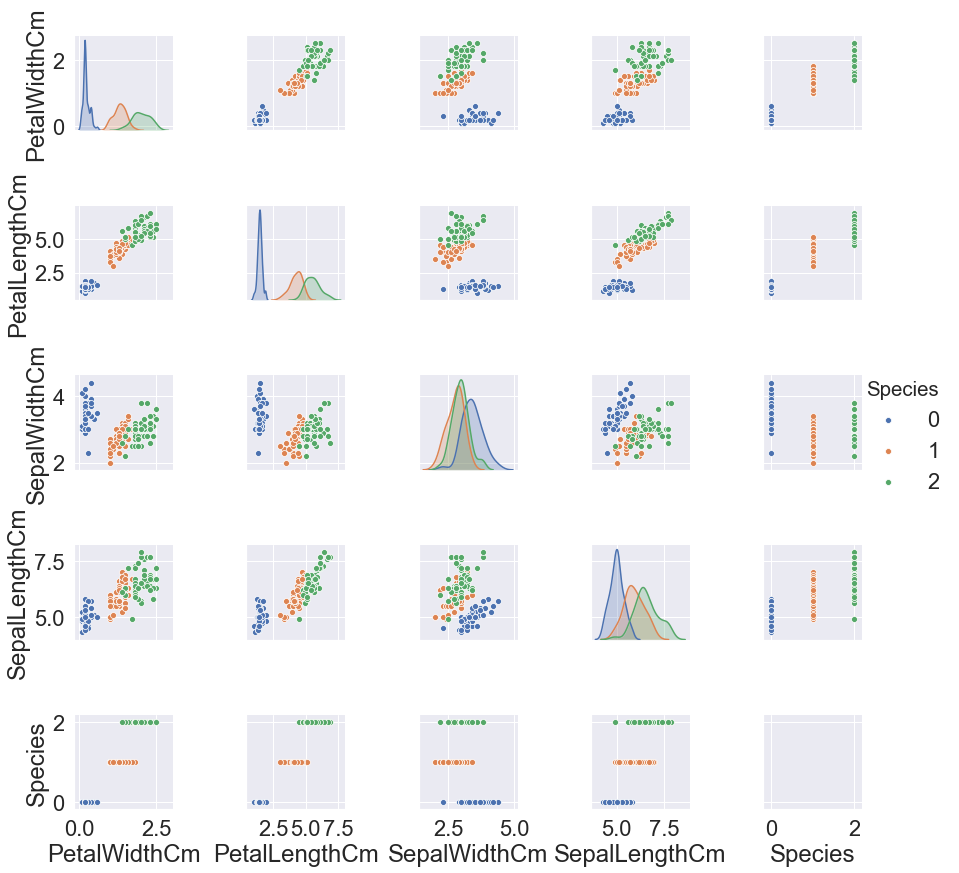

In [233]:
# Let's try the Seaborn pairplot
sns.pairplot(df[cont_vars + ['Species']], hue = 'Species')
plt.show()

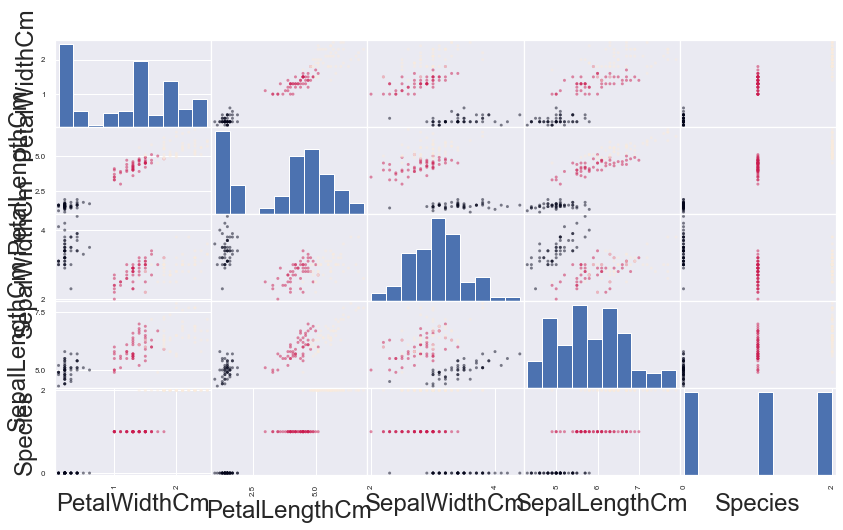

In [235]:
from pandas.plotting import scatter_matrix
# scatter plot matrix
scatter_matrix(df[cont_vars + ['Species']], c=df['Species'],figsize=(14,8))
plt.show()

### 7.2.9 3D plot

Text(0.5, 0.92, '3D plot')

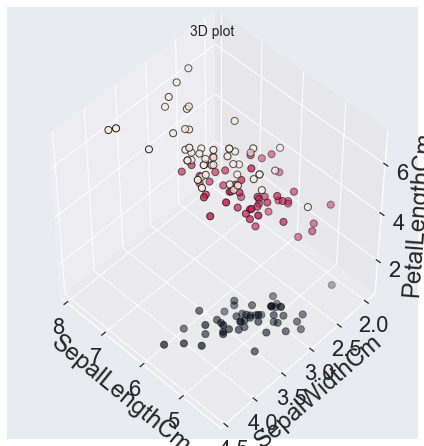

In [237]:
from mpl_toolkits.mplot3d import Axes3D

#Plotting
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(df.loc[:, 'SepalLengthCm'], df.loc[:, 'SepalWidthCm'],df.loc[:, 'PetalLengthCm'],
          c=df.Species.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("SepalLengthCm")
ax.set_ylabel("SepalWidthCm")
ax.set_zlabel("PetalLengthCm")
plt.title("3D plot", fontsize=14)

Text(0.5, 0.92, '3D plot')

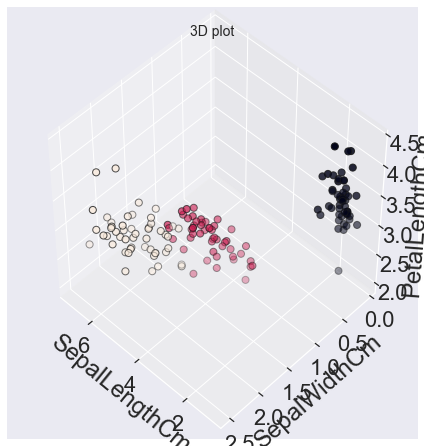

In [238]:
from mpl_toolkits.mplot3d import Axes3D

#Plotting
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(df.loc[:, 'PetalLengthCm'], df.loc[:, 'PetalWidthCm'],df.loc[:, 'SepalWidthCm'],
          c=df.Species.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("SepalLengthCm")
ax.set_ylabel("SepalWidthCm")
ax.set_zlabel("PetalLengthCm")
plt.title("3D plot", fontsize=14)

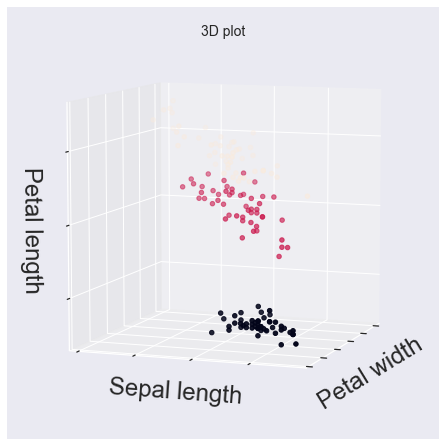

In [239]:
from mpl_toolkits.mplot3d import Axes3D

#Plotting
fig = plt.figure(1, figsize=(6,6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(df.loc[:, 'PetalWidthCm'], df.loc[:, 'SepalLengthCm'], df.loc[:, 'PetalLengthCm'], c=df.Species.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.title("3D plot", fontsize=14)
plt.show()

#### Analyze distribution

### 8.3. Datetime variables

# 9. Data Preprocessing

### 9.1. Numerical variables

#### Scaling dataset

In [241]:
numdf.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [151]:
from sklearn.preprocessing import StandardScaler
numdf_norm = pd.DataFrame(StandardScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns
numdf_norm.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


In [169]:
#from sklearn.preprocessing import MinMaxScaler
#numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(numdf))
#numdf_norm.columns = numdf.columns
#numdf_norm = numdf_norm.drop(['Target'],axis=1)
#numdf_norm.head()

### 9.2. Categorical variables

#### Create dummy varibales

#### One hot coding

### 9.3. Combine all predictors

In [153]:
print(numdf_norm.shape)
print(objdf.shape)
# print(bindf.shape)

(150, 4)
(150, 0)


In [154]:
X = pd.concat([numdf_norm,objdf], axis=1)
print (X.shape)
y = dataset['Species']
print (y.shape)

(150, 4)
(150,)


In [155]:
X.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


### 9.4. Save preprocessed data

In [156]:
df = pd.concat([X,y],axis=1)
df.to_csv('Iris-preprocessed.csv',index=False)

In [157]:
X.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


# 10. Splitting the dataset into the Training set and Test set

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [159]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

# 11. Model Selection

### 11. 1. Initialize the classifier models with their default parameters and add them to the list

In [162]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(kernel="linear")))
models.append(('LSVC', SVC(kernel="rbf")))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('LGB',LGBMClassifier()))
models.append(('ADA',AdaBoostClassifier()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('NN',MLPClassifier()))
models.append(('XGB',XGBClassifier()))

### 11.2. Config parameters

In [163]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

### 11.3. Train models

In [164]:
# evaluate each model in turn
results = {}
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.947727 (0.056737)
SVC: 0.955303 (0.060459)
LSVC: 0.956061 (0.059920)
LR: 0.947727 (0.069800)
DT: 0.955303 (0.044748)
GNB: 0.947727 (0.056737)
RF: 0.956061 (0.044018)
GB: 0.946970 (0.043387)
LGB: 0.947727 (0.056737)
ADA: 0.947727 (0.056737)
QDA: 0.973485 (0.040550)
NN: 0.930303 (0.083937)
XGB: 0.956061 (0.044018)


In [165]:
results_df = pd.DataFrame(results)
results_df

,KNN,SVC,LSVC,LR,DT,GNB,RF,GB,LGB,ADA,QDA,NN,XGB
0,0.916667,1.000000,0.916667,0.916667,1.000000,0.916667,0.916667,0.916667,0.916667,0.916667,1.000000,0.916667,0.916667
1,0.833333,0.916667,0.916667,0.833333,0.916667,0.833333,0.916667,0.916667,0.833333,0.833333,0.916667,0.750000,0.916667
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.909091,0.909091,1.000000,1.000000,1.000000,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.909091,1.000000
5,1.000000,1.000000,1.000000,1.000000,0.909091,1.000000,1.000000,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.909091,1.000000,1.000000,1.000000,0.909091,1.000000,0.909091,0.909091,0.909091,0.909091,1.000000,1.000000,0.909091
8,0.909091,0.818182,0.818182,0.818182,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.818182,0.909091
9,1.000000,0.909091,1.000000,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091


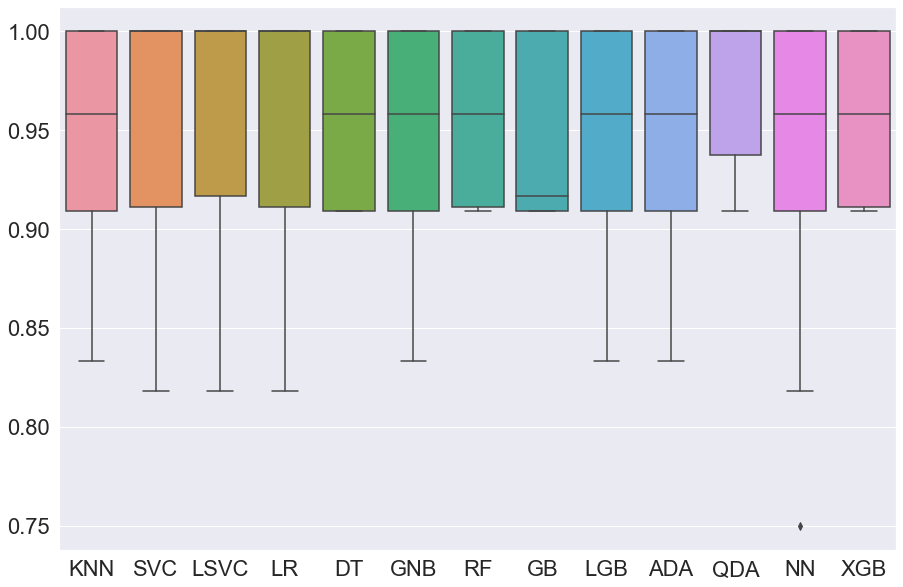

In [166]:
plt.figure(figsize=(15,10))
sns.boxplot(data=results_df)
plt.show()

### 11.4. Predicting

In [167]:
# Make predictions on validation dataset
for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print('Accuracy score: ',accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))

KNN
Accuracy score:  0.9736842105263158
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38

SVC
Accuracy score:  0.9736842105263158
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38

LSVC
Accuracy score:  0.9736842105263158
                 precision    recall  f1-score   support

    Iris-setosa  

KNN: 0.947727 (0.056737)
SVC: 0.955303 (0.060459)
LSVC: 0.956061 (0.059920)
LR: 0.947727 (0.069800)
DT: 0.963636 (0.044536)
GNB: 0.947727 (0.056737)
RF: 0.956061 (0.044018)
GB: 0.946970 (0.043387)
LGB: 0.947727 (0.056737)
ADA: 0.938636 (0.054886)
QDA: 0.973485 (0.040550)
NN: 0.938636 (0.068304)
XGB: 0.956061 (0.044018)
        KNN       SVC      LSVC        LR        DT       GNB        RF        GB       LGB       ADA       QDA        NN       XGB
0  0.916667  1.000000  0.916667  0.916667  1.000000  0.916667  0.916667  0.916667  0.916667  0.916667  1.000000  0.916667  0.916667
1  0.833333  0.916667  0.916667  0.833333  1.000000  0.833333  0.916667  0.916667  0.833333  0.833333  0.916667  0.833333  0.916667
2  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
3  0.909091  0.909091  1.000000  1.000000  1.000000  0.909091  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
4  1.000000  1.0000

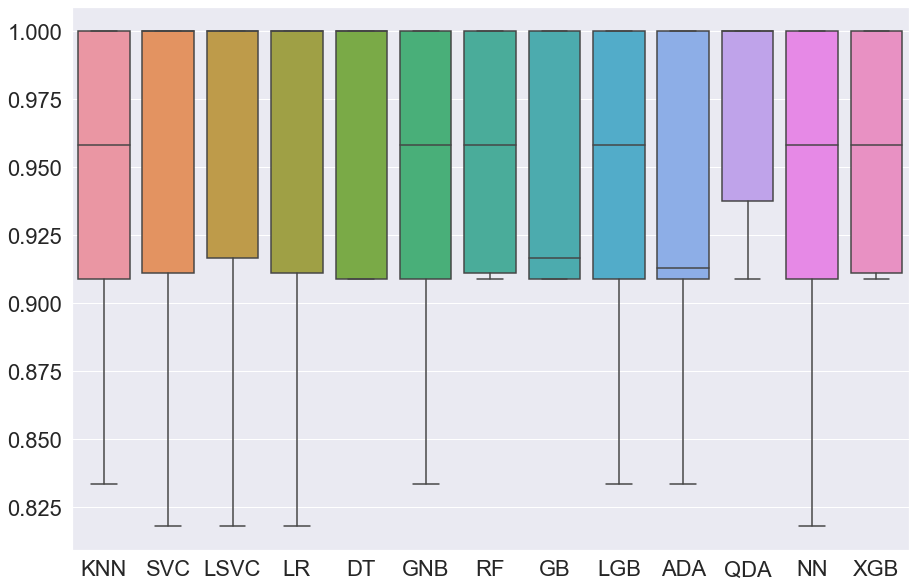

KNN
Accuracy score:  0.9736842105263158
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38

SVC
Accuracy score:  0.9736842105263158
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.90      1.00      0.95         9

       accuracy                           0.97        38
      macro avg       0.97      0.98      0.97        38
   weighted avg       0.98      0.97      0.97        38

LSVC
Accuracy score:  0.9736842105263158
                 precision    recall  f1-score   support

    Iris-setosa  

In [168]:
ModelSelection(X_train, y_train, X_test, y_test)